<font size=14><center><b>simulation pour déterminer la fréquence nécessaire<br>de mise à jour du modèle de segmentation</b></center></font>

# Imports

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from datetime import datetime
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sqlite3

from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, scale
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


# Fonctions

In [2]:
def CreationDir(dossier):
    """
    Crée le répertoire si il n'existe pas
    """
    if not os.path.exists(dossier):
        os.makedirs(dossier)




# Constantes

In [3]:
dossierImage = "images/"  # chemin ou déposer les images
CreationDir(dossierImage)
dossierDatas = "datas/"   # chemin ou déposer les exports
CreationDir(dossierDatas)

In [4]:
# date d'execution du notebook pour pallier a l'ancienneté de la base
CURENT_DATE = "2018-10-18"

# Récupération des DataFrames

In [5]:
# Chargement des données
import re
from os import walk

def importFile2Df(file):
    print(f'Import fichier {file}')
    globals()[f'{file[:-4]}'] = pd.read_csv(f'{dossierDatas}{file}',
                                            sep='|',
                                            lineterminator='\n',
                                            encoding='utf-8')

f = []
for (dirpath, dirnames, filenames) in walk(dossierDatas):
    f.extend(filenames)
    for filename in filenames:
#        if filename.startswith('df20'): # problème avec les autres DF
        if re.search("^df20.._T", filename):
            importFile2Df(filename)

Import fichier df2016_T4.csv
Import fichier df2017_T1.csv
Import fichier df2017_T2.csv
Import fichier df2017_T3.csv
Import fichier df2017_T4.csv
Import fichier df2018_T1.csv
Import fichier df2018_T2.csv
Import fichier df2018_T3.csv


# Vérification des Df chargés

In [6]:
all_df = %who_ls DataFrame
print(f'Dataframes chargés : {all_df}')

Dataframes chargés : ['df2016_T4', 'df2017_T1', 'df2017_T2', 'df2017_T3', 'df2017_T4', 'df2018_T1', 'df2018_T2', 'df2018_T3']


In [7]:
userList = df2016_T4['id_uniq_custom']
userList

0      f7b62c75467e8ce080b201667cbbc274
1      7a176e5d88c7acb6000a055e008c055d
2      0ecf7f65b5ff3b9e61b637e59f495e0a
3      ffb973f2bb1c0cb807a99341a9b20dcd
4      ff8557b296729eaa30f078d974c86812
                     ...               
321    0313291a6f4f16df04dcf819d88c38ef
322    01f156677184504063bd19739f924af1
323    00f0b70fdcb8a6e1671b52a2472bd41f
324    009b0127b727ab0ba422f6d9604487c7
325    0032c76b20340da25249092a268ce66c
Name: id_uniq_custom, Length: 326, dtype: object

# Mise aux normes des dataFrames

In [8]:
def GetUsersInDf(df,userList):
    """
    Filtre les individus qui ne sont pas
    dans userList du dataframe donné
    """
    index2Del = globals()[f'{df}'][globals()[f'{df}']['id_uniq_custom']\
                .isin(userList) == False].index
    print(f'{len(index2Del)} individus doivent être éffacés de {df}')
    globals()[f'{df}'].drop(index2Del, inplace=True)
    restants = len(globals()[f'{df}'])
    print(f'{restants} individus restants dans {df}')

for dfId in all_df:
    if dfId.startswith('df20'):
        GetUsersInDf(dfId,userList)

0 individus doivent être éffacés de df2016_T4
326 individus restants dans df2016_T4
5082 individus doivent être éffacés de df2017_T1
326 individus restants dans df2017_T1
14145 individus doivent être éffacés de df2017_T2
326 individus restants dans df2017_T2
26340 individus doivent être éffacés de df2017_T3
326 individus restants dans df2017_T3
43635 individus doivent être éffacés de df2017_T4
326 individus restants dans df2017_T4
63991 individus doivent être éffacés de df2018_T1
326 individus restants dans df2018_T1
83303 individus doivent être éffacés de df2018_T2
326 individus restants dans df2018_T2
95769 individus doivent être éffacés de df2018_T3
326 individus restants dans df2018_T3


In [9]:
df2018_T3

,id_uniq_custom,montant_min,montant_max,montant_moy,montant_tot,nb_order,max_nb_articles,review_min,review_moy,review_max,...,retard_min,retard_moy,retard_max,livraison_min,livraison_moy,livraison_max,estimation_moy,R,F,M
218,32ea3bdedab835c3aa6cb68ce66565ef,25.99,49.00,34.96,4720.05,3,1,4.0,4.7,5.0,...,-11.0,-6.0,0.0,5.0,12.0,23.0,18,93,3,35
325,f7b981e8a280e455ac3cbe0d5d171bd1,10.90,10.90,10.90,6627.20,2,1,5.0,5.0,5.0,...,-21.0,-20.0,-20.0,4.0,5.0,6.0,26,632,2,11
326,f7b62c75467e8ce080b201667cbbc274,30.97,59.90,54.93,41252.93,2,2,1.0,1.5,4.0,...,-45.0,-18.0,-12.0,7.0,36.0,42.0,54,722,2,55
783,ccafc1c3f270410521c3c6f3b249870f,41.99,132.40,87.20,6103.65,2,1,5.0,5.0,5.0,...,-42.0,-27.0,-12.0,13.0,15.0,17.0,43,114,2,87
1360,94e5ea5a8c1bf546db2739673060c43f,54.90,97.88,76.39,5194.52,2,1,5.0,5.0,5.0,...,-28.0,-20.0,-13.0,5.0,15.0,25.0,36,143,2,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94960,0313291a6f4f16df04dcf819d88c38ef,95.00,95.00,95.00,16245.00,1,1,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,81,720,1,95
95377,01f156677184504063bd19739f924af1,739.98,739.98,739.98,18499.50,1,1,5.0,5.0,5.0,...,-45.0,-45.0,-45.0,7.0,7.0,7.0,52,719,1,740
95728,00f0b70fdcb8a6e1671b52a2472bd41f,0.00,0.00,0.00,0.00,1,0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,42,725,1,0
95860,009b0127b727ab0ba422f6d9604487c7,0.00,0.00,0.00,0.00,1,0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,16,746,1,0


# Préparation et Fit du modèle

In [10]:
# Chargement des données
df = pd.read_csv(dossierDatas+'df.csv',
                 sep='|',
                 lineterminator='\n',
                 encoding='utf-8')

In [11]:
def preProcessingData(dfIn):
    df = pd.DataFrame(globals()[f'{dfIn}'][['R', 'F', 'M']])
    # on supprime les clients avec un montant moyen = 0
    index2Del = df.loc[df['M']==0].index
    df.drop(index2Del, inplace=True)
    # on limite le nombre de commandes a 5
    df.loc[df['F']>5,'F']=5
    # application du log et du minMaxScaler
    df['M'] = MinMaxScaler().fit_transform(np.log1p(df[['M']]))
    df['F'] = MinMaxScaler().fit_transform(np.log1p(df[['F']]))
    df['R'] = MinMaxScaler().fit_transform(df[['R']])
    print(f'dataFrame {dfIn} : {df.shape[0]} individus \
            et {df.shape[1]} variables')
    return df

In [12]:
dfModele = preProcessingData('df')

dataFrame df : 95420 individus             et 3 variables


In [13]:
variableIn = dfModele
initialisation_modele = 'k-means++'
random_state = 42
n_init = 1
nbCluster=6

In [14]:
modele = KMeans(nbCluster,
                n_init=n_init,
                init=initialisation_modele,
                random_state=random_state).fit(variableIn)

# Calcul de l'ARI pour tous les trimestres

In [15]:
from sklearn.metrics.cluster import adjusted_rand_score

def getARI(modele, dfIdPrec, dfId):
    print(f'{dfIdPrec} --> {dfId}')
    resultMod1 = modele.predict(preProcessingData(dfIdPrec))
    resultMod2 = modele.predict(preProcessingData(dfId))
    ARI = adjusted_rand_score(resultMod1, resultMod2)
    print(f'Score ARI : {ARI}')
    dfRetour = pd.DataFrame({"Trimestre":[dfId[2:]], "ARI":[ARI]})
    return dfRetour

In [16]:
n=0
dfResult = pd.DataFrame()
for dfId in all_df:
    n += 1
    if n > 1:
        dfResult = dfResult._append(getARI(modele, dfIdPrec, dfId),
                                    ignore_index=True)
    dfIdPrec = dfId

df2016_T4 --> df2017_T1
dataFrame df2016_T4 : 309 individus             et 3 variables
dataFrame df2017_T1 : 309 individus             et 3 variables
Score ARI : 0.6769357124824688
df2017_T1 --> df2017_T2
dataFrame df2017_T1 : 309 individus             et 3 variables
dataFrame df2017_T2 : 309 individus             et 3 variables
Score ARI : 0.2719262573700516
df2017_T2 --> df2017_T3
dataFrame df2017_T2 : 309 individus             et 3 variables
dataFrame df2017_T3 : 309 individus             et 3 variables
Score ARI : 0.7581474294493699
df2017_T3 --> df2017_T4
dataFrame df2017_T3 : 309 individus             et 3 variables
dataFrame df2017_T4 : 309 individus             et 3 variables
Score ARI : 0.9285059368047476
df2017_T4 --> df2018_T1
dataFrame df2017_T4 : 309 individus             et 3 variables
dataFrame df2018_T1 : 309 individus             et 3 variables
Score ARI : 0.8794989988591879
df2018_T1 --> df2018_T2
dataFrame df2018_T1 : 309 individus             et 3 variables
dataFram

In [17]:
dfResult

,Trimestre,ARI
0,2017_T1,0.676936
1,2017_T2,0.271926
2,2017_T3,0.758147
3,2017_T4,0.928506
4,2018_T1,0.879499
5,2018_T2,0.782308
6,2018_T3,1.000000


# Visualisation de l'ARI

In [18]:
# mise en forme pour graphe
dfResult['Trimestre'] = dfResult['Trimestre'].str.replace("_", " ")

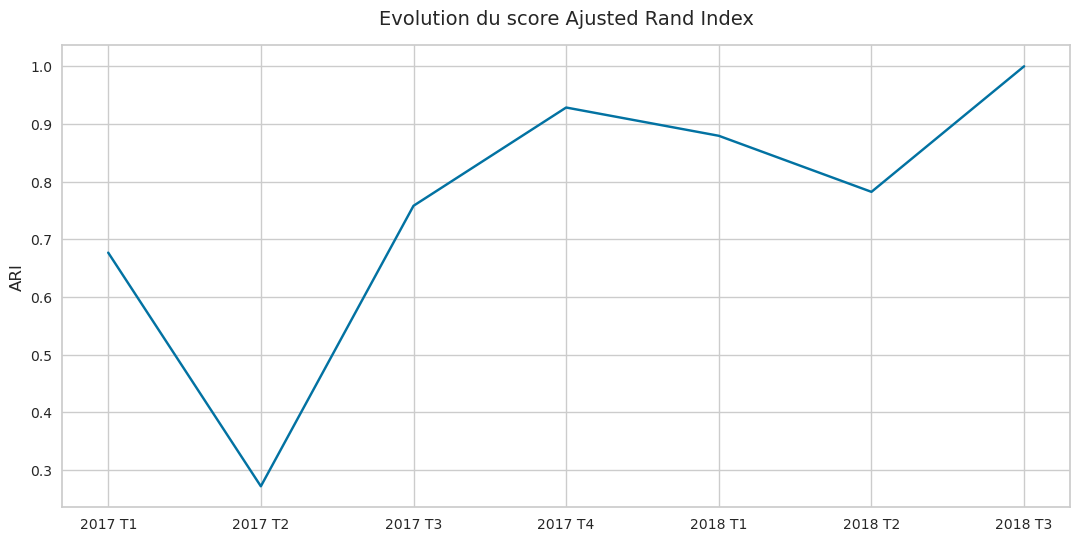

In [19]:
titre = "Evolution du score Ajusted Rand Index"
plt.figure(figsize=(13, 6))
plt.title(titre, fontsize=14)
sns.set_style("whitegrid")
plt.plot(dfResult['Trimestre'],dfResult['ARI'])
plt.title(titre, fontsize=14, pad=15)
plt.ylabel('ARI', fontsize=12)
plt.savefig(dossierImage+titre+'.jpg')
plt.show()

> L'ARI chute au bout de 2 Trimestres